# A Basic Neural Network implementation



Let's start by first importing numpy and math library

We need numpy for matrix operations (matrix-vector multiplication and transposing a matrix)

In [1]:
import numpy as np
import math

We define an activation function that returns the value f(x) and the derivative at the position f'(x)

In [2]:
def actF(x):
    act = math.tanh(x)
    return [act, 1-act*act]

Next, we define a class for a non-linear transformation, called _NodeLayer_. These are the layers of the NN, regardless whether input, hidden, or output. As parameters it has
- the number of nodes in the layer
- an array of the input values (called bottom values)
- an array of the output values (called top values)
- an array of the derivatives of the input values
- an array containing the gradient coming from the top (called top error gradient)
- an array containing the gradient at the bottom (called bottom error gradient)
- whether or not it is an output layer

In [3]:
class NodeLayer:

    def __init__(self, nrNodes, outputLayer=False):
        self.nrNodes = nrNodes
        self.outputLayer = outputLayer
        self.bottom_values = np.zeros([nrNodes])
        self.top_values = np.zeros([nrNodes])
        self.derivative_of_values = np.zeros([nrNodes])

        self.top_error_grad = np.zeros([nrNodes])
        self.bottom_error_grad = np.zeros([nrNodes])

Then, we need a `forward pass` and a `backward pass` function. 

The forwards pass computes the activation function for each value in the bottom values and
- stores the result in the top values array
- stores the derivative in the `derivative_of_values` array

The backward pass takes the error gradient at top and multiplies the derivative to produce the error gradient at the bottom

In [4]:
    def forward_pass(self):
        if self.outputLayer == False:
            for nodeNo in range(self.nrNodes):
                self.top_values[nodeNo], self.derivative_of_values[nodeNo] = actF(self.bottom_values[nodeNo])
    
    def backward_pass(self):
        for nodeNo in range(self.nrNodes):
            self.bottom_error_grad[nodeNo] = self.derivative_of_values[nodeNo] * self.top_error_grad[nodeNo]

For the output layer, we implement the softmax normalization:
- compute the exponentiated value
- divide each output by the sum of all exponentiated values

In [5]:
    def softmax_normalization(self):
        self.top_values = np.array([math.exp(v) for v in self.bottom_values])
        softmax_sum = np.sum(self.top_values)
        self.top_values /= softmax_sum
        

For the linear transformations we implement another class _WeightConnections_. Like the _NodeLayer_ class, we have some parameters for the values and the gradients and the same functions.

The class variables are
- the number of input nodes (nrNodesIn)
- the number of output nodes (nrNodesOut)
- a randomly initialized weight matrix of size nrNodesIn+1 x nrNodesOut
    - the input dimensions is one larger than the number of input nodes to simulate the bias by a constant 1 input
as well as again the bottom and top values
- input values (bottom_values)
- output values (top_values)
- the error gradient coming in from the top (top_error_grad)
- the error gradient to be passed to the rest of the network (bottom_error_grad)
- the error gradient wrt. to the individual weights (delta)


In [6]:
class WeightConnection:

    def __init__(self, nrNodesIn, nrNodesOut):
        self.nrNodesIn=nrNodesIn
        self.nrNodesOut=nrNodesOut
        self.weights = np.random.uniform(-1,1, [nrNodesOut, nrNodesIn+1])
        
        self.bottom_values = np.zeros([nrNodesIn])
        self.top_values = np.zeros([nrNodesOut])
        self.top_error_grad = np.zeros([nrNodesOut])
        self.bottom_error_grad = np.zeros([nrNodesIn])
        self.delta = np.zeros(self.weights.shape)

We have again a `forward pass` and a `backward pass` function. In the forward pass, we extend the input by one `1` and multiply the input with the matrix to get 
![top_values = W*bottom_values + bias]()

In the backward pass, we multiply the top error gradient with the matrix to pass it to the bottom. Since we multiply the value _from the other side_, we transpose the matrix before we do the matrix-vector multiplication.

In [7]:
    def forward_pass(self):
        #add 1 as value to introduce bias
        self.bottom_values = np.concatenate([self.bottom_values, [1]])
        self.top_values = self.weights.dot(self.bottom_values)


    def backward_pass(self):
        self.bottom_error_grad = self.weights.transpose().dot(self.top_error_grad)

Then we have a function `add_weight_gradient` to compute the error gradient w.r.t. to the individual weights and a function `weight_update` to update the weights according to the back-propagation algorithm.

The error gradient w.r.t. to the individual weights (d/dw(ij) Error) is computed by multiplying the bottom node output[i] with the top error gradient[j].

In [8]:
    def add_weight_gradient(self):
        self.delta += np.outer(self.top_error_grad, self.bottom_values)
        
    def weight_update(self, eta):
        self.weights -= eta * self.delta
        self.delta = np.zeros(self.weights.shape)

All together we have the NN code as below.

Node, that we also add a dummy `update_weights` function to the NodeLayer to make the code cleaner. Furthermore, if we wish to extend the code in a way that a Node had trainable parameters, we can used that function.

In [9]:
import numpy as np
import math

def actF(x):
    act = math.tanh(x)
    return [act, 1-act*act]

class NodeLayer:

    def __init__(self, nrNodes, outputLayer=False):
        self.nrNodes = nrNodes
        self.outputLayer = outputLayer
        self.bottom_values = np.zeros([nrNodes])
        self.top_values = np.zeros([nrNodes])
        self.derivative_of_values = np.zeros([nrNodes])

        self.top_error_grad = np.zeros([nrNodes])
        self.bottom_error_grad = np.zeros([nrNodes])
        
    def forward_pass(self):
        if self.outputLayer == False:
            for nodeNo in range(self.nrNodes):
                self.top_values[nodeNo], self.derivative_of_values[nodeNo] = actF(self.bottom_values[nodeNo])
    
    def backward_pass(self):
        for nodeNo in range(self.nrNodes):
            self.bottom_error_grad[nodeNo] = self.derivative_of_values[nodeNo] * self.top_error_grad[nodeNo]
            
    def softmax_normalization(self):
        self.top_values = np.array([math.exp(v) for v in self.bottom_values])
        softmax_sum = np.sum(self.top_values)
        self.top_values /= softmax_sum
        
    def update_weights(self, eta):
        pass
        
class WeightConnection:

    def __init__(self, nrNodesIn, nrNodesOut):
        self.nrNodesIn=nrNodesIn
        self.nrNodesOut=nrNodesOut
        self.weights = np.random.uniform(-1,1, [nrNodesOut, nrNodesIn+1])
        
        self.bottom_values = np.zeros([nrNodesIn])
        self.top_values = np.zeros([nrNodesOut])
        self.top_error_grad = np.zeros([nrNodesOut])
        self.bottom_error_grad = np.zeros([nrNodesIn])
        self.delta = np.zeros(self.weights.shape)
        
    def forward_pass(self):
        #add 1 as value to introduce bias
        self.bottom_values = np.concatenate([self.bottom_values, [1]])
        self.top_values = self.weights.dot(self.bottom_values)


    def backward_pass(self):
        self.bottom_error_grad = self.weights.transpose().dot(self.top_error_grad)
        
    def add_weight_gradient(self):
        self.delta += np.outer(self.top_error_grad, self.bottom_values)
        
    def update_weights(self, eta):
        self.weights = self.weights - eta * self.delta
        self.delta = np.zeros(self.weights.shape) 

A NN can now be expressed as an array that has a sequence of transformation, alternating non-linear NodeLayer and linear Weight connections.

The number of nodes in the layers and the size of the weight matrices must fit. 

For the last layer, we add that this is an output layer, so we do softmax normalization instead.

In [10]:
#now, the network
nn = []
nn.append(NodeLayer(2))     # input nodes
nn.append(WeightConnection(2, 10))

nn.append(NodeLayer(10))
nn.append(WeightConnection(10, 5))

nn.append(NodeLayer(5))
nn.append(WeightConnection(5, 2))
nn.append(NodeLayer(2, outputLayer=True))

The forward pass for an input vector x is now the following:

1. we insert in the vector x into the `top_values` of the first NN layer (the input nodes)
2. then we iterate through the rest of the network:
    - copy the top_value of the previous layer into the bottom_value of the current layer
    - do the forward pass in that layer
3. Do the softmax normalization of the values in the output layer

In [11]:
def forward_pass(nn, x):
    nn[0].top_values = x

    for layerNo, layer in enumerate(nn[1:]):
        layer.bottom_values = nn[layerNo].top_values
        layer.forward_pass()

    nn[-1].softmax_normalization()
    
    return nn[-1].top_values

The backward pass given a target value is similarly quick:

1. Insert the error gradient of the network output and the target value into the `bottom_error_grad` of the top layer
2. iterate through the network, from top to bottom:
    - copy the `bottom error gradient` of the higher layer into the `top_error_grad` array of the current layer
    - call the `backward pass` function of the current layer
    
Note, that we do not explicitly compute the error function. Instead we use the simple error gradient, given the softmax normalization of the output layer and the cross-entropy error as 

![d/do E = nn(x) - target]()

In [12]:
def backward_pass(nn, target):
    nn[-1].bottom_error_grad = nn[-1].top_values - target
    for layerNo in range(len(nn)-2, -1, -1):
        nn[layerNo].top_error_grad = nn[layerNo+1].bottom_error_grad
        nn[layerNo].backward_pass()

Now, for each sample in the training set, a forward pass and a backward pass belong together. Hence, we group them in a `forward_backward_pass` function. Given as input x and target y, do
1. forward pass
2. backward pass
3. weight update (on-line training)
    - off-line training or mini-bach training would be a bit different here


In [13]:
def forward_backward_pass(nn, x, y):
    forward_pass(nn, x)
    backward_pass(nn, y)

    for layerNo in range(1,len(nn), 2): #only the weight connection layers
        nn[layerNo].add_weight_gradient()

We can update the parameters of the network (the weights in the WeightConnections) by iterating over the layers of the network and calling the update_weight function with the learning rate eta. 

In [14]:
def update_weights(nn, eta):

    for layer in nn: #only the weight connection layers
        layer.update_weights(eta)

The training procedure is now a simple function, that takes a training array (containing tuples of (x,y), already in a 1-hot encoding), the number of steps and the learning rate

In [15]:
def training(nn, tr, steps, eta):
    for _ in range(steps):
        for x,y in tr:
            forward_backward_pass(nn, x, y)
            update_weights(nn, eta)

given a small database, we can test our system

In [16]:
        
#training
steps = 200
tr = [
    ([0.8,0.2], [1, 0]),
    ([-0.5, 1], [1, 0]),
    ([-1, -1.5], [1, 0]),
    
    
    ([0.0, 1], [0,1]),
    ([0.2, 0.4], [0, 1]),
    ([-1.5, 0], [0, 1])
]

training(nn, tr, steps=5000, eta=0.003)

We can test the output space by randomly creating a few points (here 8000 points), evaluating the NN at those points, and plot the resulting output probability. We wrap the plotting functionality in its own function with a callback to the neural network, so we can evaluate the input space wherever the plot_it functions desires

In [17]:
from __future__ import print_function
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
import matplotlib.mlab as mlab
import time
%matplotlib inline


def plot_it(x_min=-2, x_max=2, y_min=-2, y_max=2, npts=8000, dataset=[], nn_callback=None):
    xi = np.linspace(x_min, x_max, 100)
    yi = np.linspace(y_min, y_max, 100)


    x = np.random.uniform(x_min, x_max, npts)
    y = np.random.uniform(y_min, y_max, npts)
    z=[]
    for i in range(npts):
        #forward_pass(nn, [x[i], y[i]])[0]
        z.append(nn_callback(nn, [x[i], y[i]])[0] )
    zi = mlab.griddata(x, y, z, xi, yi, interp='linear')
    plt.contour(xi, yi, zi, 0, linewidths=0.5, colors='k')
    plt.contourf(xi, yi, zi, 15,
                 norm=plt.Normalize(vmax=abs(zi).max(), vmin=-abs(zi).max()))
    plt.colorbar()  # draw colorbar

    tr_points_x = [a[0] for a, b in dataset if b == [1,0]]
    tr_points_y = [a[1] for a, b in dataset  if b == [1,0]]
    plt.plot(tr_points_x, tr_points_y, 'yo', ms=4)


    tr_points_x = [a[0] for a, b in dataset if b == [0,1]]
    tr_points_y = [a[1] for a, b in dataset  if b == [0,1]]
    plt.plot(tr_points_x, tr_points_y, 'go', ms=4)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    
    


## Training  Summary


All together, the training and plotting code is

training in seconds: 1.015438


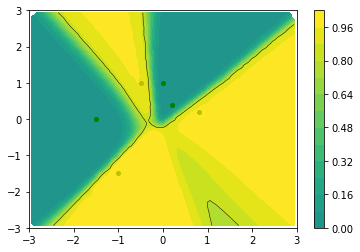

In [18]:


#now, the network
nn = []
nn.append(NodeLayer(2))     # input nodes
nn.append(WeightConnection(2, 10))

nn.append(NodeLayer(10))
nn.append(WeightConnection(10, 5))

nn.append(NodeLayer(5))
nn.append(WeightConnection(5, 2))
nn.append(NodeLayer(2, outputLayer=True))

def forward_pass(nn, x):
    nn[0].top_values = x

    for layerNo, layer in enumerate(nn[1:]):
        layer.bottom_values = nn[layerNo].top_values
        layer.forward_pass()

    nn[-1].softmax_normalization()
    
    return nn[-1].top_values

def backward_pass(nn, target):
    nn[-1].bottom_error_grad = nn[-1].top_values - target
    for layerNo in range(len(nn)-2, -1, -1):
        nn[layerNo].top_error_grad = nn[layerNo+1].bottom_error_grad
        nn[layerNo].backward_pass()
        
def forward_backward_pass(nn, x, y):
    forward_pass(nn, x)
    backward_pass(nn, y)

    for layerNo in range(1,len(nn), 2): #only the weight connection layers
        nn[layerNo].add_weight_gradient()
        
def update_weights(nn, eta):

    for layer in nn: #only the weight connection layers
        layer.update_weights(eta)
        
def training(nn, tr, steps, eta):
    for _ in range(steps):
        for x,y in tr:
            forward_backward_pass(nn, x, y)
            update_weights(nn, eta)
            
        
#training
tr = [
    ([0.8,0.2], [1, 0]),
    ([-0.5, 1], [1, 0]),
    ([-1, -1.5], [1, 0]),
    
    
    ([0.0, 1], [0,1]),
    ([0.2, 0.4], [0, 1]),
    ([-1.5, 0], [0, 1])
]

start = time.clock()
training(nn, tr, steps=1000, eta=0.01)
print('training in seconds: %f' % (time.clock() - start))

plot_it(nn_callback=forward_pass,
        dataset=tr,
       x_min=-3, x_max=3,
       y_min=-3, y_max=3)


## Regularization

### L2 Regularization

The L2 Norm reduces to a weight decay

w = (1-alpha)*w - delta

In [19]:
    def update_weights_regularized(self, eta, reg="", alpha=0):
        if reg == "L2":
            self.weights = (1-eta*alpha)*self.weights - eta * self.delta
        self.delta = np.zeros(self.weights.shape) 

The L1 Norm substracts or adds a constant term alpha, depending no whether the gradient is positive or not. 


In [20]:
    def update_weights_regularized(self, eta, reg="", alpha=0):
        if reg == "L2":
            self.weights = (1-eta*alpha)*self.weights - eta * self.delta
            
        elif reg == "L1":
            self.weights = self.weights - eta * (self.delta + alpha * np.sign(self.weights))
            
        else:
            self.weights = self.weights - eta * self.delta

        self.delta = np.zeros(self.weights.shape)

The Neural Network code with added regularization. Note that we add again a dummy `update_weights_regularized` function to the `NodeLayer` class

In [21]:
import numpy as np
import math

def actF(x):
    act = math.tanh(x)
    return [act, 1-act*act]

class NodeLayer:

    def __init__(self, nrNodes, outputLayer=False):
        self.nrNodes = nrNodes
        self.outputLayer = outputLayer
        self.bottom_values = np.zeros([nrNodes])
        self.top_values = np.zeros([nrNodes])
        self.derivative_of_values = np.zeros([nrNodes])

        self.top_error_grad = np.zeros([nrNodes])
        self.bottom_error_grad = np.zeros([nrNodes])
        
    def forward_pass(self):
        if self.outputLayer == False:
            for nodeNo in range(self.nrNodes):
                self.top_values[nodeNo], self.derivative_of_values[nodeNo] = actF(self.bottom_values[nodeNo])
    
    def backward_pass(self):
        for nodeNo in range(self.nrNodes):
            self.bottom_error_grad[nodeNo] = self.derivative_of_values[nodeNo] * self.top_error_grad[nodeNo]
            
    def softmax_normalization(self):
        self.top_values = np.array([math.exp(v) for v in self.bottom_values])
        softmax_sum = np.sum(self.top_values)
        self.top_values /= softmax_sum
        
    def update_weights(self, eta):
        pass
    
    def update_weights_regularized(self, eta, reg="", alpha=0):
        pass
        
class WeightConnection:

    def __init__(self, nrNodesIn, nrNodesOut):
        self.nrNodesIn=nrNodesIn
        self.nrNodesOut=nrNodesOut
        self.weights = np.random.uniform(-1,1, [nrNodesOut, nrNodesIn+1])
        
        self.bottom_values = np.zeros([nrNodesIn])
        self.top_values = np.zeros([nrNodesOut])
        self.top_error_grad = np.zeros([nrNodesOut])
        self.bottom_error_grad = np.zeros([nrNodesIn])
        self.delta = np.zeros(self.weights.shape)
        
    def forward_pass(self):
        #add 1 as value to introduce bias
        self.bottom_values = np.concatenate([self.bottom_values, [1]])
        self.top_values = self.weights.dot(self.bottom_values)


    def backward_pass(self):
        self.bottom_error_grad = self.weights.transpose().dot(self.top_error_grad)
        
    def add_weight_gradient(self):
        self.delta += np.outer(self.top_error_grad, self.bottom_values)
        
    def update_weights(self, eta):
        self.weights = self.weights - eta * self.delta
        self.delta = np.zeros(self.weights.shape) 

    def update_weights_regularized(self, eta, reg="", alpha=0):
        if reg == "L2":
            self.weights = (1-eta*alpha)*self.weights - eta * self.delta
        elif reg == "L1":
            self.weights = self.weights - eta * (self.delta + alpha * np.sign(self.weights))
        else:
            self.weights = self.weights - eta * self.delta
        self.delta = np.zeros(self.weights.shape)
    
    


The backward pass now has a parameter alpha and a regularization parameter to indicate what regularization to chose.

In [22]:
def forward_pass(nn, x):
    nn[0].top_values = x

    for layerNo, layer in enumerate(nn[1:]):
        layer.bottom_values = nn[layerNo].top_values
        layer.forward_pass()

    nn[-1].softmax_normalization()
    
    return nn[-1].top_values

def backward_pass(nn, target):
    nn[-1].bottom_error_grad = nn[-1].top_values - target
    for layerNo in range(len(nn)-2, -1, -1):
        nn[layerNo].top_error_grad = nn[layerNo+1].bottom_error_grad
        nn[layerNo].backward_pass()
        
        
def forward_backward_pass(nn, x, y):
    forward_pass(nn, x)
    backward_pass(nn, y)

    for layerNo in range(1,len(nn), 2): #only the weight connection layers
        nn[layerNo].add_weight_gradient()
        
def update_weights(nn, eta, alpha=0, regularization='L2'):
    for layer in nn:
        layer.update_weights_regularized(eta, alpha=alpha, reg=regularization)
        
def training(nn, tr, steps, eta, alpha=0, regularization='L2'):
    for _ in range(steps):
        for x,y in tr:
            forward_backward_pass(nn, x, y)
            update_weights(nn, eta, alpha, regularization)
          
        
#a helper function to make NN, just add a list of the number of nodes i.e. [2, 10, 5, 2]
def mkNN(nnLayer):
    nn = [NodeLayer(nnLayer[0])]
    for i in range(1, len(nnLayer)):
        nn.append(WeightConnection(nnLayer[i-1], nnLayer[i]))
        nn.append(NodeLayer(nnLayer[i], outputLayer=(i+1 == len(nnLayer))))
    return nn

Let's look at a slightly more complicated dataset, a truncated checkerboard pattern.

/usr/local/lib/python3.5/dist-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


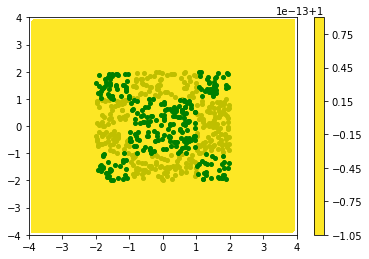

In [23]:
def mkCheckerboardPoint(x_min, x_max, y_min, y_max):
    x = np.random.uniform(x_min, x_max)
    y = np.random.uniform(y_min, y_max)
    c = 0 if int(x) % 2 == int(y) % 2 else 1
    return ([x,y], [c, 1-c])
    

checkerboard_set = [mkCheckerboardPoint(-2, 2, -2, 2) for _ in range(600)]

plot_it(nn_callback=lambda a,b:[1,0],
        dataset=checkerboard_set,
       x_min=-4, x_max=4,
       y_min=-4, y_max=4)


A NN without regularization:

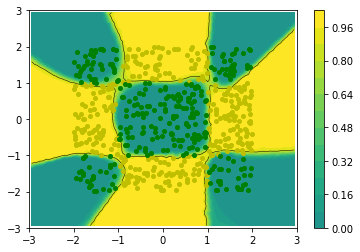

In [24]:
#A fresh NN
nn = mkNN([2, 10, 5, 2])

    
training(nn, tr=checkerboard_set, steps=200, eta=0.005, alpha=0, regularization=None)


plot_it(nn_callback=forward_pass,
        dataset=checkerboard_set,
       x_min=-3, x_max=3,
       y_min=-3, y_max=3)

With L2 regularization

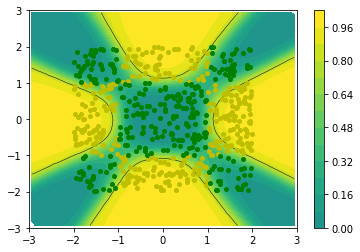

In [25]:
#A fresh NN
nn = mkNN([2, 10, 5, 2])

    
training(nn, tr=checkerboard_set, steps=200, eta=0.005, alpha=0.01, regularization="L2")


plot_it(nn_callback=forward_pass,
        dataset=checkerboard_set,
       x_min=-3, x_max=3,
       y_min=-3, y_max=3)


You can see that the decision boundary is already much smoother

Let's look at the actual weights

In [26]:

for layer in nn:
    try:
        print(layer.weights)
    except:
        print("===\n")

===

[[-1.82362663e-04 -1.64828936e-03 -1.21645951e-04]
 [ 1.11905449e+00 -1.15853760e+00  9.52751759e-01]
 [-7.87071816e-01  3.32068331e-02 -9.60881999e-01]
 [-1.08337538e+00 -1.11726691e+00  9.57284293e-01]
 [-2.09121801e-02  6.98953891e-01  8.53189285e-01]
 [-3.86872624e-02  7.28301850e-01 -8.62398048e-01]
 [-1.11466169e+00  1.13764669e+00  9.46850706e-01]
 [-6.65028834e-01  2.62667210e-02  5.81657298e-01]
 [-1.26497690e-04 -8.35675821e-03 -5.60271493e-03]
 [-1.11890024e+00 -1.12293941e+00 -9.67663092e-01]]
===

[[ 4.81050949e-04 -4.16270353e-01 -2.64609508e-01 -3.99559398e-01
   2.45534711e-01 -2.59775987e-01 -4.19996976e-01  1.77285919e-01
  -1.41513934e-03  4.24392843e-01  1.06414607e-01]
 [ 2.24517348e-03  2.47681074e-01  1.56469896e-01  2.43561832e-01
  -1.41730538e-01  1.53304480e-01  2.58325800e-01 -1.03081002e-01
  -3.12207671e-03 -2.52359338e-01 -6.03714480e-02]
 [-1.78600069e-03  3.30811348e-01  2.07136712e-01  3.15188737e-01
  -1.94569950e-01  2.04840181e-01  3.40322619e-

## L1 Regularization

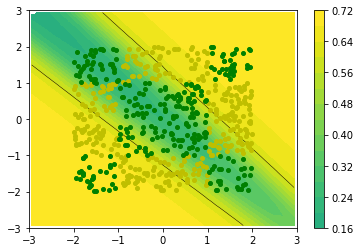

In [27]:
#A fresh NN
nn = mkNN([2, 10, 5, 2])

    
training(nn, tr=checkerboard_set, steps=200, eta=0.01, alpha=0.01, regularization="L1")


plot_it(nn_callback=forward_pass,
        dataset=checkerboard_set,
       x_min=-3, x_max=3,
       y_min=-3, y_max=3)


The decision boundary may not match well any more, the actual weights, however, are often very close to 0

In [28]:
for layer in nn:
    try:
        print(layer.weights)
    except:
        print("===\n")

===

[[ 1.15787140e-05 -1.85184569e-05 -8.82611513e-05]
 [-1.11925553e+00 -1.17776127e+00 -5.28284399e-01]
 [-4.77165798e-05 -7.03545862e-05 -4.70749542e-05]
 [ 6.31114219e-05  7.36833704e-05  1.35043051e-05]
 [ 1.29343045e+00  1.18067201e+00 -6.94870527e-01]
 [ 6.38845981e-05  7.10818207e-05  3.71493827e-05]
 [-3.70049446e-05 -7.59636583e-05 -2.63176430e-05]
 [ 6.32896359e-05  9.02251434e-05  7.48205952e-05]
 [-6.00448113e-05 -6.84716801e-05 -4.35187357e-05]
 [ 9.58774236e-05  5.41797544e-05  5.37155874e-05]]
===

[[ 7.50447286e-05  7.45242150e-05 -2.60222092e-05 -4.73503651e-05
   6.64970341e-06 -6.27625114e-05 -4.69092467e-05  7.53195103e-05
   9.00698987e-05  6.11105269e-05 -4.45211011e-06]
 [ 4.18683503e-05 -1.04365771e+00  1.43037111e-05  6.37351291e-05
  -1.03512265e+00 -3.64017320e-05  9.76612211e-06  3.27844813e-05
   3.22724799e-05 -9.04482510e-05 -4.64696678e-01]
 [ 4.44755715e-05  9.07157544e-06  5.38385696e-05 -3.10715859e-05
   5.32542623e-05 -7.84140617e-05 -2.97550466e-

## Noise Regularization

Let's add a bit of Gaussian noise to the data

Variance of noise 0.800000


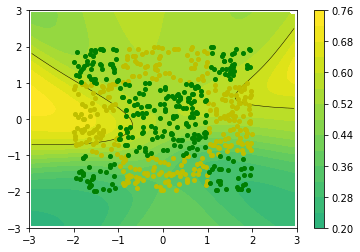

In [29]:
def training_with_noise(nn, tr, steps, eta, noise_variance):
    for _ in range(steps):
        for x,y in tr:
            noise = np.random.normal(0, noise_variance, [len(x)])
            forward_backward_pass(nn, noise+x, y)
            update_weights(nn, eta, alpha=0, regularization=None)
            
#A fresh NN
nn = mkNN([2, 10, 5, 2])

noise_variance = 0.8
print("Variance of noise %f" % noise_variance)
training_with_noise( nn, 
                     tr=[mkCheckerboardPoint(-2, 2, -2, 2) for _ in range(50)], 
                     steps=200, 
                     eta=0.01,
                     noise_variance = noise_variance)


plot_it(nn_callback=forward_pass,
        dataset=checkerboard_set,
       x_min=-3, x_max=3,
       y_min=-3, y_max=3)